# FIN 514 - Project 2 - vmenday2

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [28]:
# ENTER INPUT FOR: start_step


jmax = 100 #Number of S steps
imax = 5000 #Number of t steps
S0 =  3719.04
K = 2789.28
Barr = 2789.28
sigma = 0.3
r1 = 0.1
r2 = 0.1
q = 0
Tmat = 401/365
Tval = 398/365
tco = [36/365,66/365,97/365,128/365,156/365,187/365,217/365,248/365,
278/365,309/365,340/365,370/365,401/365]
tac = [34/365,64/365,95/365,126/365,154/365,182/365,215/365,246/365,
276/365,307/365,338/365,368/365,398/365]
cpn = .116
imax = 5000
jmaxmin = 200
jmaxmax =500
jmaxstep = 50
tauto = 182/365

SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

In [29]:
CNFD_barrier(S0, K, Barr, Tmat, Tval, tco, tac, tauto, cpn, r1, r2, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax)

[{'S_steps': 200,
  't_steps': 5000,
  'CN': 1203683.9026329531,
  'Barrier Lambda': 0.9999999999999963},
 {'S_steps': 250,
  't_steps': 5000,
  'CN': 1835985.1798328126,
  'Barrier Lambda': 0.9999999999999987},
 {'S_steps': 300,
  't_steps': 5000,
  'CN': 2701024.4928686456,
  'Barrier Lambda': 0.9999999999999915},
 {'S_steps': 350,
  't_steps': 5000,
  'CN': 3673812.4670342137,
  'Barrier Lambda': 1.0000000000000036},
 {'S_steps': 400,
  't_steps': 5000,
  'CN': 4796011.380174616,
  'Barrier Lambda': 0.9999999999999866},
 {'S_steps': 450,
  't_steps': 5000,
  'CN': 5992495.924938406,
  'Barrier Lambda': 1.000000000000006}]

## Crank-Nicolson Finite Difference Function - continuous

In [27]:

def CNFD_barrier(S0, K, Barr, Tmat, Tval, tco, tac, tauto, cpn, r1, r2, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfdb_result = []
    

    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
        V = np.zeros([imax+1, jmax+1]) # if trigger event has occured
        
        P = np.zeros([imax+1, jmax+1]) # if trigger event has not occured

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
    
    # Set up time and S steps
    
        dt = Tval / imax
        
        dS = SU/jmax
        
        
        jb = int(Barr/dS)
        if (jb*dS > Barr): jb = jb-1
        
        ji = int(S0/dS)
        if (ji*dS > S0): ji = ji-1
        
        ico1 = [j/dt for j in tco] # coupon payment dates
        ico = [int(j) for j in ico1] # nearest time point to coupon payment dates
        
        icp = [j<tauto for j in ico1]
        
        
    
        iac1 = [j/dt for j in tac] # observation date
        iac = [int(j) for j in iac1] # nearest time point to observation date
        ibarrier = iac
    
    
        
    # CALCULATE OPTION VALUES AND PROBABILITIES in the case of "TRIGGER EVENT"
    # Start at the last step number because we are going to be moving backwards from times step imax to times step 0
    
        i = imax 
        
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            if j>ji:
                V[i, j] = 1000*(1+cpn)*np.exp(-r2*(Tmat-Tval))
            elif j>jb: 
                V[i, j] = (dS*j/dS*ji)*1000*(1+cpn)*np.exp(-r2*(Tmat-Tval))
            else: V[i, j] = (dS*j/dS*ji)*1000*np.exp(-r2*(Tmat-Tval))
                    
            
            A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
            B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
            C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j
            
            
            if j>jb:
                P[i, j] = 1000*(1+cpn)*np.exp(-r2*(Tmat-Tval))
            else: P[i, j] = V[i, j]

    #Now go back in time
        for i in range(imax-1, -1, -1):
            
            if (i in ibarrier):  

                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                #regular D values
                for j in range(1, jmax, 1):

                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0

                if i>0:
                    IAC1 = [K/i for K in ico1]

                    IAC =  [int(K) for K in IAC1]
                    TNCi = min(IAC)

                if i >= tauto: 
                    D[jmax] = 1000*(1+cpn)*np.exp(-r2*(TNCi-dt*i))
                else: 
                    cpk = np.zeros(5)
                    for k in range(5):
                        if icp[k] >i:
                            cpk[k] = 1000*cpn*np.exp(-r2(icp[k]*dt-i*dt))

                    D[jmax] = 1000*(1+cpn)*np.exp(-r2*(tauto-dt*i))*(sum(cpk))

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,jmax] = CN_S[jmax]/alpha[jmax]
                if i in iac:
                    V[i,jmax] = V[i,jmax] + 1000*cpn*np.exp(-r2*(tco[iac.index(i)]-dt*i))
                for j in range(jmax-1,-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]
                    if i in iac:
                        V[i,j] = V[i,j] + 1000*cpn*np.exp(-r2*(tco[iac.index(i)]-dt*i))
            else:

                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                #regular D values
                for j in range(1, jmax, 1):

                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = 1000*(1+cpn)

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,jmax] = CN_S[jmax]/alpha[jmax]

                for j in range(jmax-1,-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]               
                
        
                
      ################################################################################
        i = imax 
        
        for j in range(jb, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            P[i, j] = 1000*(1+cpn)*np.exp(-r2*(Tmat-Tval))
            A[j] = 0.25*sigma**2*j**2 - 0.25*(r1-q)*j
            B[j] = -1/dt-0.5*r1-0.5*sigma**2*j**2
            C[j] = 0.25*sigma**2*j**2 + 0.25*(r1-q)*j

    #Now go back in time
        for i in range(imax-1, -1, -1):
            
            if (i in ibarrier):

                #Lower boundary condition in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = V[i, j]

                #regular D values
                for j in range(jb+1, jmax, 1):

                    D1 = -P[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -P[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -P[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0

                if i>0:
                    IAC1 = [K/i for K in ico1]

                    IAC =  [int(K) for K in IAC1]
                    TNCi = min(IAC)

                if i >= tauto: 
                    D[jmax] = 1000*(1+cpn)*np.exp(-r2*(TNCi-dt*i))
                else: 
                    cpk = np.zeros(5)
                    for k in range(5):
                        if icp[k] >i:
                            cpk[k] = 1000*cpn*np.exp(-r2(icp[k]*dt-i*dt))

                    D[jmax] = 1000*(1+cpn)*np.exp(-r2*(tauto-dt*i))*(sum(cpk))


                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                P[i,jmax] = CN_S[jmax]/alpha[jmax]

                if i in iac:
                    P[i,jmax] = P[i,jmax] + 1000*cpn*np.exp(-r2*(tco[iac.index(i)]-dt*i))

                for j in range(jmax-1,jb-1,-1):
                    P[i,j] = (CN_S[j]-C[j]*P[i,j+1])/alpha[j]
                    if i in iac:
                        P[i,j] = P[i,j] + 1000*cpn*np.exp(-r2*(tco[iac.index(i)]-dt*i))
            else:
                
                #Lower boundary condition in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = V[i, j]

                #regular D values
                for j in range(jb+1, jmax, 1):

                    D1 = -P[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r1-q)*j)
                    D2 = -P[i+1,j]*(1/dt-0.5*r1-0.5*sigma**2*j**2)
                    D3 = -P[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r1-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = 1000*(1+cpn)
                
                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                P[i,jmax] = CN_S[jmax]/alpha[jmax]

                for j in range(jmax-1,jb-1,-1):
                    P[i,j] = (CN_S[j]-C[j]*P[i,j+1])/alpha[j]


            

                
    # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Barr/dS)+1
        Pcrit = P[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (P[0,jcrit+1] - P[0,jcrit])
        Blambda = (jcritB*dS - Barr)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Pcrit, 'Barrier Lambda': Blambda}
        cnfdb_result.append(output)

    return cnfdb_result


0

In [49]:
cnfd = CNFD_barrier(S0, K, Barr, T, r, q, sigma, SU, 50, 500, 50, 5000)

In [50]:
exact = 4.39750256

In [51]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [52]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - exact 
df

,S_steps,t_steps,CN,Barrier Lambda,error_cn
0,50,5000,4.349961,1.0,-0.047541
1,100,5000,4.386211,1.0,-0.011292
2,150,5000,4.392527,1.0,-0.004975
3,200,5000,4.394712,1.0,-0.002790
4,250,5000,4.395719,1.0,-0.001783
5,300,5000,4.396265,1.0,-0.001238
6,350,5000,4.396594,1.0,-0.000909
7,400,5000,4.396807,1.0,-0.000696
8,450,5000,4.396953,1.0,-0.000550


In [53]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/cn.csv", index=False)

CN finite difference error profile with lamba kept at 0/1 to ensure the continuous barrier is on a layer of grid points

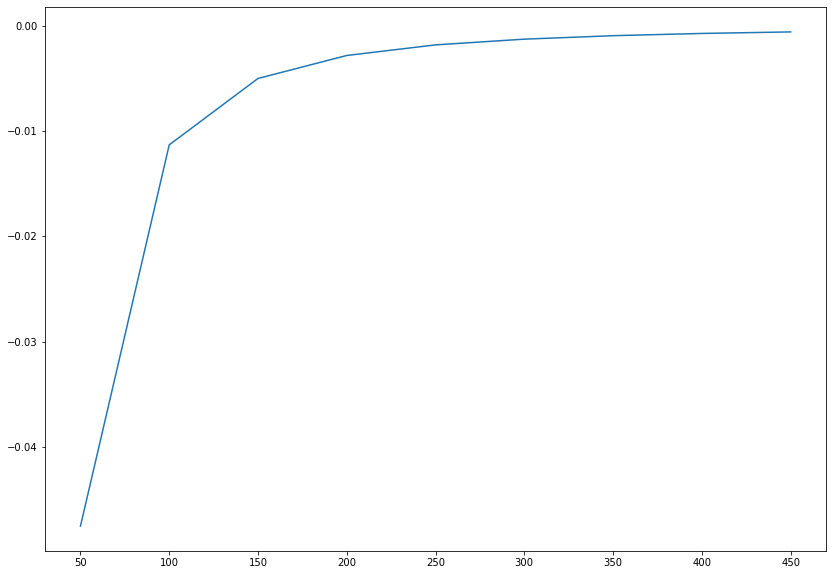

In [54]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cnbarr1.png')
plt.show()

In [61]:
cnfd = CNFD_barrier(S0, K, Barr, T, r, q, sigma, SU, 40, 500, 10, 5000)

In [62]:
exact = 4.39750256

In [63]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [64]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - exact 
df

,S_steps,t_steps,CN,Barrier Lambda,error_cn
0,40,5000,4.889579,0.8,0.492077
1,50,5000,4.349961,1.0,-0.047541
2,60,5000,5.602847,0.2,1.205345
3,70,5000,5.287658,0.4,0.890155
4,80,5000,4.969818,0.6,0.572315
5,90,5000,4.666971,0.8,0.269469
6,100,5000,4.386211,1.0,-0.011292
7,110,5000,5.198893,0.2,0.801390
8,120,5000,4.983381,0.4,0.585878
9,130,5000,4.776026,0.6,0.378523


In [65]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/cn.csv", index=False)

CN finite difference error profile with varying lambda

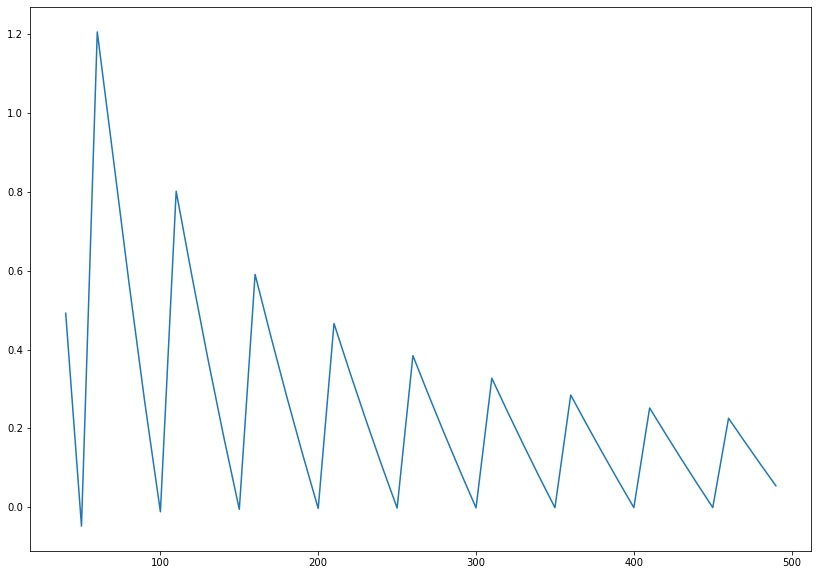

In [66]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cnbarr2.png')
plt.show()

## Discrete barrier option with correct lambda

In [103]:

def CNFD_discbarrier(S0, K, Barr, T, r, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfddb_result = []
    
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
        V = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
    
    # Set up time and S steps
    
        dt = T / imax
        dS = SU/jmax
        jb = int(Barr/dS)
        if (jb*dS > Barr): jb = jb-1  
            
        ico1 = [j/dt for j in tco] # coupon payment dates
        ico = [int(j) for j in ico1] # nearest time point to coupon payment dates
        
        icp = [j<tauto for j in ico1]
        
        
    
        iac1 = [j/dt for j in tac] # observation date
        iac = [int(j) for j in iac1] # nearest time point to observation date
    
  
            
        ibarrier = iac
      
        
    # CALCULATE OPTION VALUES AND PROBABILITIES
    # Start at the last step number because we are going to be moving backwards from times step imax to times step 0
    
        i = imax 
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            V[i, j] = np.maximum(j*dS-K, 0)

    #Now go back in time
        for i in range(imax-1, -1, -1):

            if (i in ibarrier):    
                #Lower boundary condition in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = 0
    
                #regular D values
                for j in range(jb+1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                    D[j] = D1+D2+D3
            
                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = SU*np.exp(-q*(T-i*dt))-K*np.exp(-r*(T-i*dt))
            
                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,jb-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]
            
            else:
            
                #Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                #regular D values
                for j in range(1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                    D[j] = D1+D2+D3

                #Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = SU*np.exp(-q*(T-i*dt))-K*np.exp(-r*(T-i*dt))


                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
                V[i,jmax] = CN_S[jmax]/alpha[jmax]
                for j in range(jmax-1,-1,-1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]
                
    # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Barr/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Blambda = (jcritB*dS - Barr)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Barrier Lambda': Blambda}
        cnfddb_result.append(output)

    return cnfddb_result


In [104]:
cndiscbarr = CNFD_discbarrier(S0, K, Barr, T, r, q, sigma, SU, 75, 475, 50, 5000)

In [105]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cndiscbarr)
df

,S_steps,t_steps,CN,Barrier Lambda
0,75,5000,5.694924,0.5
1,125,5000,5.678456,0.5
2,175,5000,5.674051,0.5
3,225,5000,5.672096,0.5
4,275,5000,5.670957,0.5
5,325,5000,5.670169,0.5
6,375,5000,5.669558,0.5
7,425,5000,5.669049,0.5


In [106]:
exact = 5.6711051343

In [107]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - exact
df

,S_steps,t_steps,CN,Barrier Lambda,error_cn
0,75,5000,5.694924,0.5,0.023819
1,125,5000,5.678456,0.5,0.007351
2,175,5000,5.674051,0.5,0.002946
3,225,5000,5.672096,0.5,0.000991
4,275,5000,5.670957,0.5,-0.000148
5,325,5000,5.670169,0.5,-0.000936
6,375,5000,5.669558,0.5,-0.001547
7,425,5000,5.669049,0.5,-0.002056


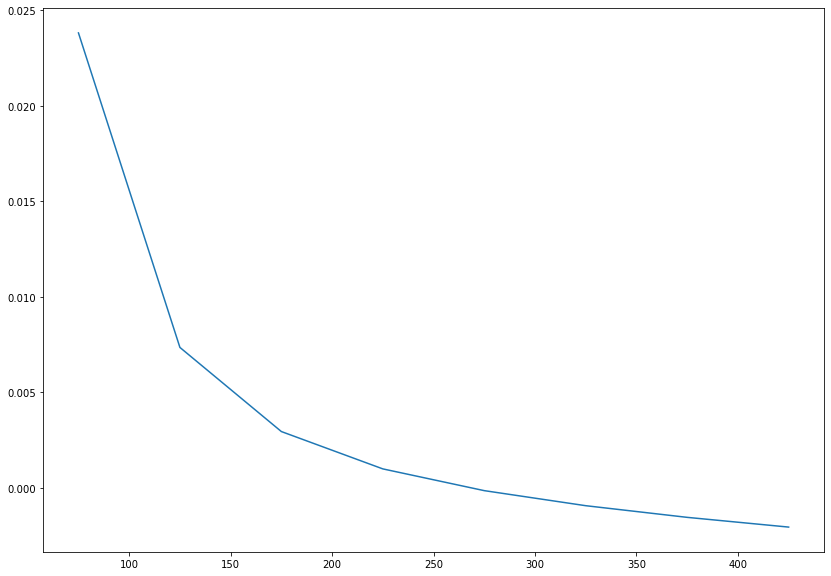

In [108]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cndiscb.png')
plt.show()

## Discrete barrier, now with varying lambdas

In [78]:
cndiscbarr = CNFD_discbarrier(S0, K, Barr, T, r, q, sigma, SU, 40, 500, 10, 5000)

In [79]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cndiscbarr)
df

,S_steps,t_steps,CN,Barrier Lambda
0,40,5000,5.367782,0.8
1,50,5000,5.124491,1.0
2,60,5000,5.908831,0.2
3,70,5000,5.765068,0.4
4,80,5000,5.627706,0.6
5,90,5000,5.503982,0.8
6,100,5000,5.394989,1.0
7,110,5000,5.808549,0.2
8,120,5000,5.720537,0.4
9,130,5000,5.637774,0.6


In [80]:
exact = 5.6711051343

In [81]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - exact
df

,S_steps,t_steps,CN,Barrier Lambda,error_cn
0,40,5000,5.367782,0.8,-0.303323
1,50,5000,5.124491,1.0,-0.546614
2,60,5000,5.908831,0.2,0.237726
3,70,5000,5.765068,0.4,0.093963
4,80,5000,5.627706,0.6,-0.043399
5,90,5000,5.503982,0.8,-0.167123
6,100,5000,5.394989,1.0,-0.276116
7,110,5000,5.808549,0.2,0.137444
8,120,5000,5.720537,0.4,0.049432
9,130,5000,5.637774,0.6,-0.033331


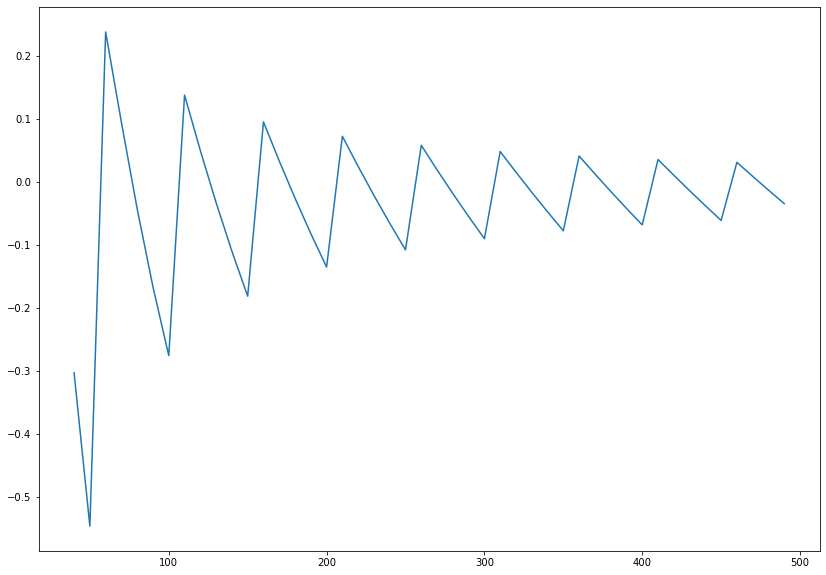

In [82]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cndiscb.png')
plt.show()